# Requerimientos y carga de datos

In [ ]:
!pip install pandas
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import io

Cargamos el archivo: GSE46579_AD_ngs_data_summarized_NORMAL.xlsx

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GSE46579_AD_ngs_data_summarized_NORMAL.xlsx to GSE46579_AD_ngs_data_summarized_NORMAL.xlsx


# Preparación de los datos

Trasponemos la matriz para facilitar el anális

In [ ]:
df = pd.read_excel(io.BytesIO(uploaded['GSE46579_AD_ngs_data_summarized_NORMAL.xlsx']))

# Trasponiendo el DataFrame
data_transposed = df.set_index('Unnamed: 0').T
new_columns = data_transposed.columns.tolist()

print(data_transposed.shape)
data_transposed_head = data_transposed.head()
(data_transposed_head, new_columns[:10])

(70, 503)


(Unnamed: 0  hsa-mir-30a:hsa-miR-30a-3p  hsa-mir-550a-1:hsa-miR-550a-3p  \
 AD                          172.300000                      467.342857   
 AD.1                        132.885714                      988.000000   
 AD.2                        282.371429                      818.942857   
 AD.3                        179.371429                      557.442857   
 AD.4                        117.857143                     1055.000000   
 
 Unnamed: 0  hsa-mir-29a:hsa-miR-29a-3p  hsa-mir-378e:hsa-miR-378e  \
 AD                           41.828571                   1.757143   
 AD.1                         79.664286                   1.564286   
 AD.2                         66.121429                   3.321429   
 AD.3                         73.135714                   0.728571   
 AD.4                         65.542857                   0.500000   
 
 Unnamed: 0  hsa-mir-155:hsa-miR-155-5p  hsa-mir-628:hsa-miR-628-3p  \
 AD                           30.357143                

# Función generación datos sintéticos MWO

In [ ]:
# Función para generar datos sintéticos
def generate_synthetic_samples(data, n_samples):
    new_samples = []
    n_original = len(data)

    if n_original > 1:
        for _ in range(n_samples):
            idx1, idx2 = np.random.choice(range(n_original), 2, replace=False)
            sample1, sample2 = data.iloc[idx1], data.iloc[idx2]
            weight = np.random.rand()
            synthetic_sample = sample1 * (1 - weight) + sample2 * weight
            new_samples.append(synthetic_sample)
        return pd.DataFrame(new_samples, columns=data.columns)
    else:
        print("Not enough original samples to generate synthetic data.")
        return pd.DataFrame()


#Función generación datos sintéticos KDE

In [ ]:
# Función para generar datos sintéticos usando KDE
def generate_synthetic_samples_kde(data, n_samples):
    kde = gaussian_kde(data.T)  # Transponemos para que las características estén en las filas
    synthetic_samples = kde.resample(n_samples).T  # Transponemos de nuevo para obtener las muestras en las filas
    return pd.DataFrame(synthetic_samples, columns=data.columns)

# Función evaluación de modelos y configuración Cross Validation

In [ ]:
def evaluate_model(model, X, y, cv):
    pipeline = make_pipeline(StandardScaler(), model)
    accuracies = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    precisions = cross_val_score(pipeline, X, y, cv=cv, scoring='precision')
    recalls = cross_val_score(pipeline, X, y, cv=cv, scoring='recall')
    f1s = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

    print(f"{model.__class__.__name__} - Accuracy scores: {accuracies.mean()}")
    print(f"{model.__class__.__name__} - Precision scores: {precisions.mean()}")
    print(f"{model.__class__.__name__} - Recall scores: {recalls.mean()}"
    )
    print(f"{model.__class__.__name__} - F1 scores: {f1s.mean()}")
    print(f"{model.__class__.__name__} - AUC scores for each fold are:", scores)
    print(f"{model.__class__.__name__} - Average AUC score:", scores.mean())


# Modelos a evaluar
models = [
    SVC(kernel='linear', probability=True),
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

# Configuración de la validación cruzada
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Modelo 3 variables

## Selección de características para el modelo de 3 variables

Seleccionamos los 3 miARN correspondientes a las biofirmas.

Definimos etiquetas AD = 1 y control = 0

In [ ]:
# Buscando las columnas específicas de nuevo en el conjunto transpuesto
selected_3miRNAs = ["hsa-miR-30d-5p", "hsa-miR-29c-3p", "Brain-miR-182"]
found_3miRNAs_transposed = {miRNA: col for col in new_columns for miRNA in selected_3miRNAs if miRNA.lower() in col.lower()}
found_3miRNAs_transposed

# Extraemos las columnas de interés para las miRNAs
features_3_miRNAs = data_transposed[[found_3miRNAs_transposed['hsa-miR-30d-5p'],
                                   found_3miRNAs_transposed['hsa-miR-29c-3p'],
                                   found_3miRNAs_transposed['Brain-miR-182']]].copy()

# Añadimos una columna de etiquetas basadas en si la muestra pertenece a un
# paciente con AD o un control
labels3 = ['AD' if 'AD' in label else 'control' for label in features_3_miRNAs.index]

# Convertimos las etiquetas en binario: AD = 1, control = 0
labels3_binary = [1 if label == 'AD' else 0 for label in labels3]

# Uniendo las etiquetas con los datos de las miRNAs
features_3_miRNAs.loc[:, 'label'] = labels3_binary

# Mostrando las primeras filas para verificar la preparación de los datos
features_3_miRNAs.head(), features_3_miRNAs['label'].value_counts()


(Unnamed: 0  hsa-mir-30d:hsa-miR-30d-5p  hsa-mir-29c:hsa-miR-29c-3p  \
 AD                        16431.185714                   41.828571   
 AD.1                      18412.171429                   67.857143   
 AD.2                      19986.471429                   63.014286   
 AD.3                      22008.228571                   58.828571   
 AD.4                      19986.471429                   58.335714   
 
 Unnamed: 0  brain-mir-182:brain-mir-182  label  
 AD                             4.528571      1  
 AD.1                           7.757143      1  
 AD.2                           2.042857      1  
 AD.3                           6.271429      1  
 AD.4                           1.771429      1  ,
 label
 1    48
 0    22
 Name: count, dtype: int64)

### Análisis estadístico de las características para datos originales:

Media, varianzas y boxplot

Medias - Datos Originales
                                    Media
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   15985.584286
hsa-mir-29c:hsa-miR-29c-3p      78.267653
brain-mir-182:brain-mir-182      4.426837
label                            0.685714

Varianzas - Datos Originales
                                 Varianza
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   3.885446e+07
hsa-mir-29c:hsa-miR-29c-3p   1.440497e+03
brain-mir-182:brain-mir-182  1.058759e+01
label                        2.186335e-01


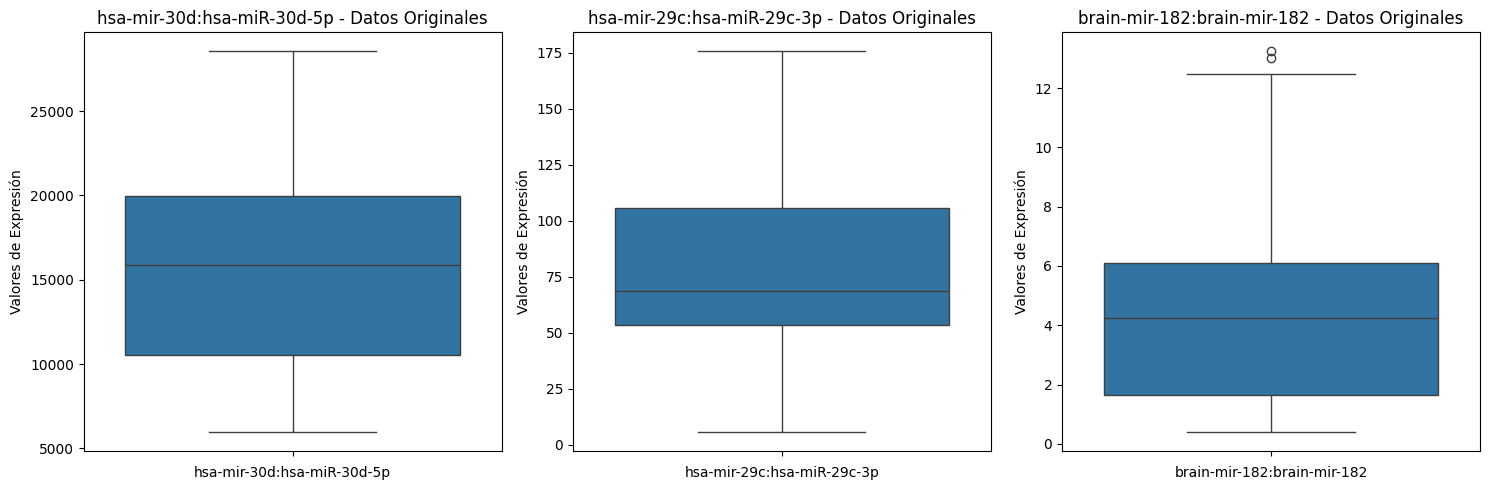

In [ ]:
# Estadísticas descriptivas para los datos originales
mean_original = features_3_miRNAs.mean()
variance_original = features_3_miRNAs.var()

mean_original_df = mean_original.to_frame(name="Media")
variance_original_df = variance_original.to_frame(name="Varianza")

print("Medias - Datos Originales")
print(mean_original_df)
print("\nVarianzas - Datos Originales")
print(variance_original_df)

plt.figure(figsize=(15, 5))
for i, column in enumerate(features_3_miRNAs.columns[:-1], 1):  # Excluyendo la columna 'label'
    plt.subplot(1, 3, i)
    sns.boxplot(y=features_3_miRNAs[column])
    plt.title(f'{column} - Datos Originales')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()

Histograma datos originales (Densidad)

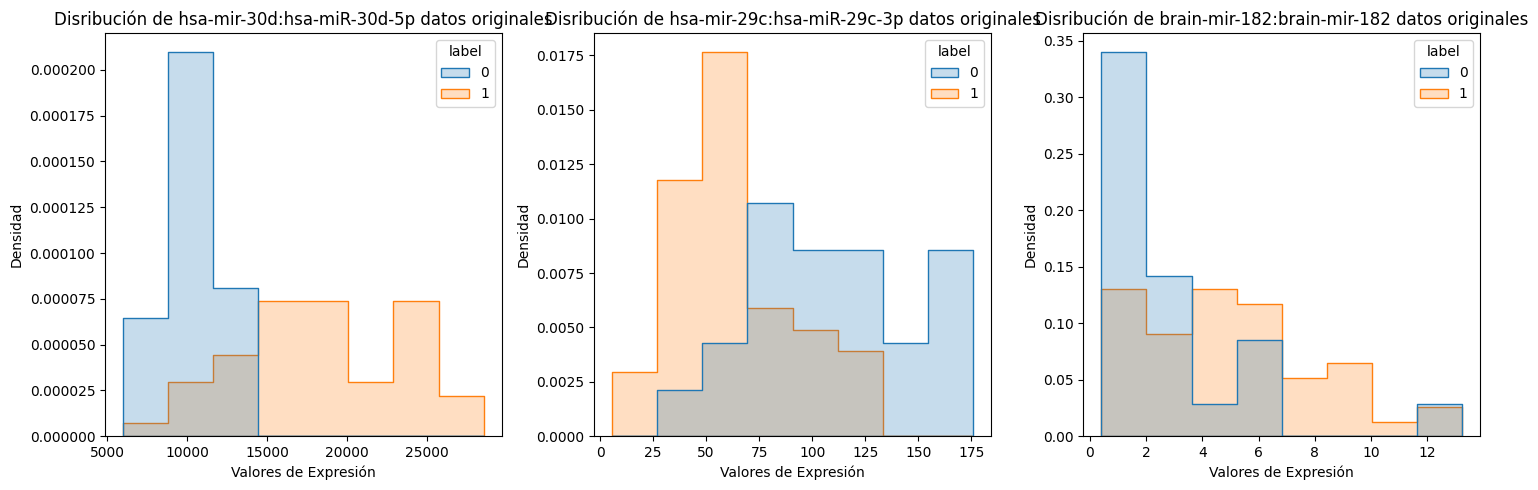

In [ ]:
plt.figure(figsize=(15, 5))
for i, column in enumerate(features_3_miRNAs.columns[:-1], 1):  # Excluyendo la columna 'label'
    plt.subplot(1, 3, i)
    sns.histplot(data=features_3_miRNAs, x=column, hue='label', element='step', stat='density', common_norm=False)
    plt.title(f'Disribución de {column} datos originales')
    plt.xlabel('Valores de Expresión')
    plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

## Aumento de datos MWO

In [ ]:
n_AD_original = sum(features_3_miRNAs['label'] == 1)
n_control_original = sum(features_3_miRNAs['label'] == 0)

synthetic_AD = generate_synthetic_samples(features_3_miRNAs[features_3_miRNAs['label'] == 1], 100 * n_AD_original)
synthetic_control = generate_synthetic_samples(features_3_miRNAs[features_3_miRNAs['label'] == 0], 100 * n_control_original)

# Combinar con los datos originales
augmented_data = pd.concat([features_3_miRNAs, synthetic_AD, synthetic_control])
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)  # Mezclar los datos

# Contar y mostrar el número de muestras generadas
n_AD_augmented = len(synthetic_AD)
n_control_augmented = len(synthetic_control)
print(f"Generated samples for AD: {n_AD_augmented}")
print(f"Generated samples for Control: {n_control_augmented}")

Generated samples for AD: 4800
Generated samples for Control: 2200


### Análisis estadístico de las características para datos aumentados MWO:

Medias - Datos Aumentados MWO
                                    Media
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   15898.332382
hsa-mir-29c:hsa-miR-29c-3p      78.269218
brain-mir-182:brain-mir-182      4.436679
label                            0.685714

Varianzas - Datos Aumentados MWO
                                 Varianza
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   3.032031e+07
hsa-mir-29c:hsa-miR-29c-3p   1.096676e+03
brain-mir-182:brain-mir-182  7.179547e+00
label                        2.155407e-01


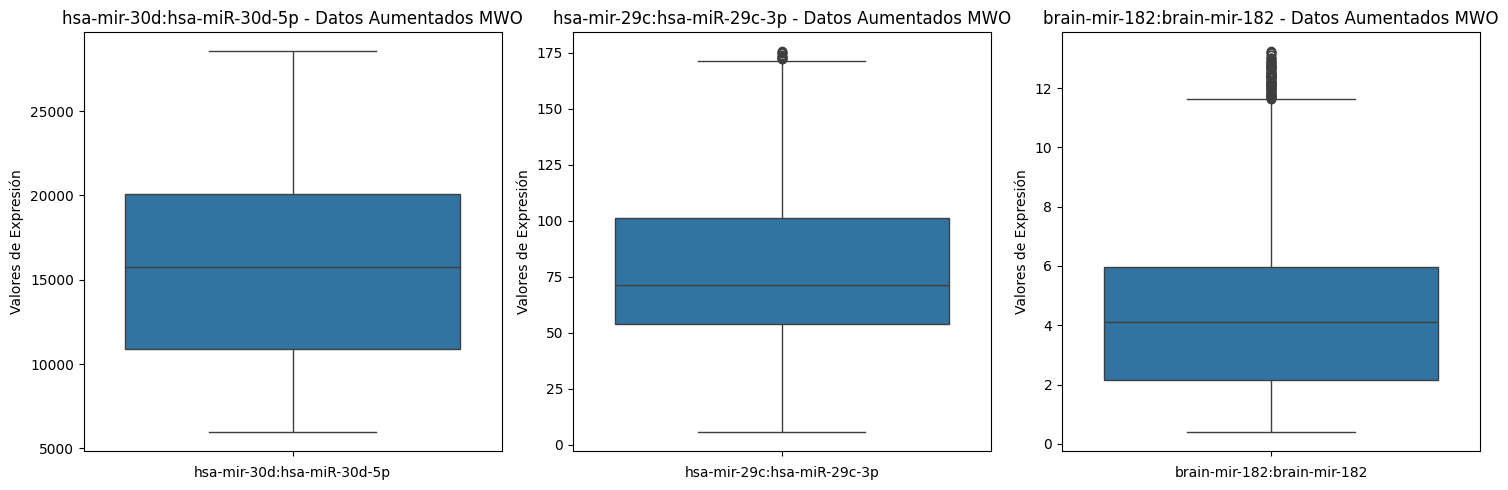

In [ ]:
# Estadísticas descriptivas para los datos aumentados
mean_augmented = augmented_data.mean()
variance_augmented = augmented_data.var()

# Crear DataFrames para medias y varianzas
mean_augmented_df = mean_augmented.to_frame(name="Media")
variance_augmented_df = variance_augmented.to_frame(name="Varianza")

print("Medias - Datos Aumentados MWO")
print(mean_augmented_df)
print("\nVarianzas - Datos Aumentados MWO")
print(variance_augmented_df)

import matplotlib.pyplot as plt
import seaborn as sns

# Datos Aumentados
plt.figure(figsize=(15, 5))
for i, column in enumerate(augmented_data.columns[:-1], 1):  # Excluyendo la columna 'label'
    plt.subplot(1, 3, i)
    sns.boxplot(y=augmented_data[column])
    plt.title(f'{column} - Datos Aumentados MWO')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()


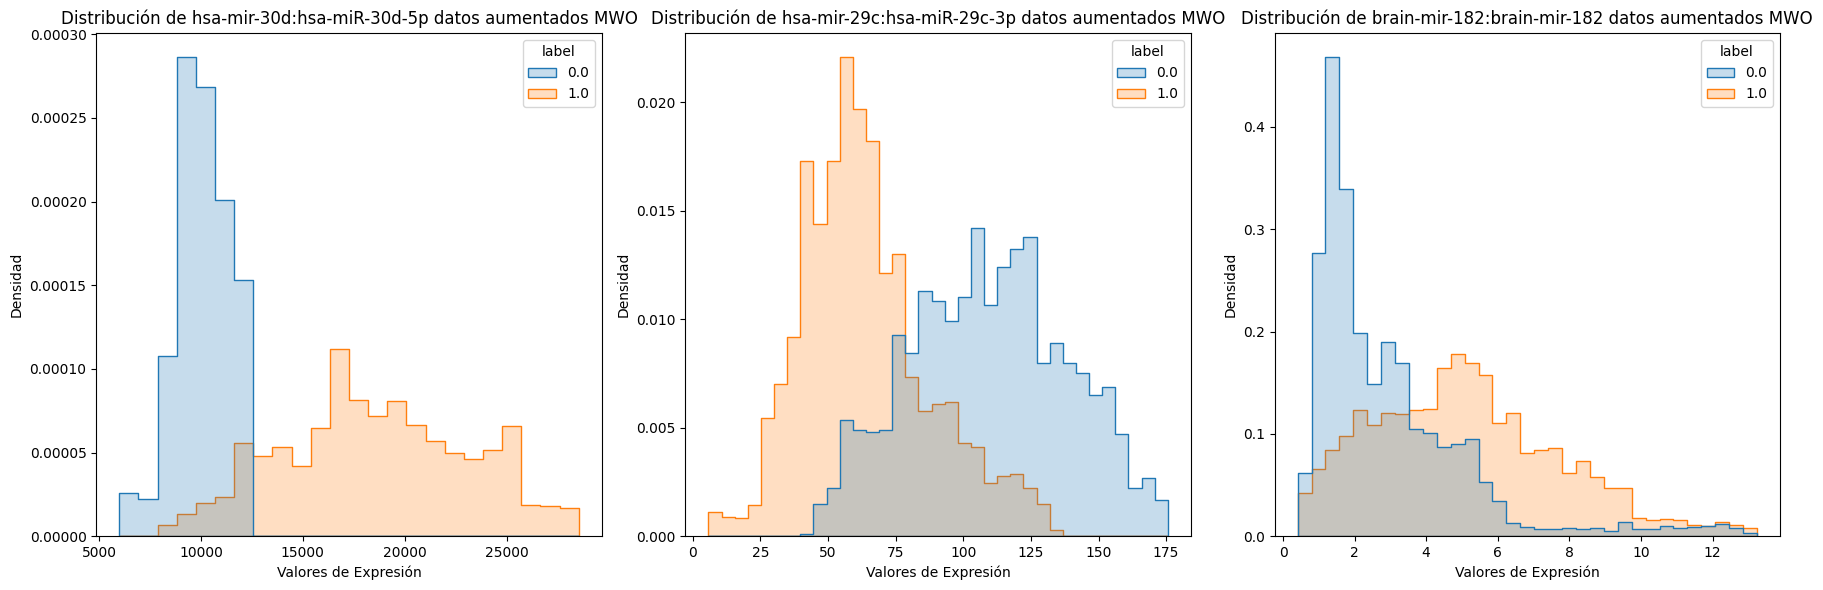

In [ ]:
# Graficar las distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, column in enumerate(['hsa-mir-30d:hsa-miR-30d-5p', 'hsa-mir-29c:hsa-miR-29c-3p', 'brain-mir-182:brain-mir-182']):
    sns.histplot(data=augmented_data, x=column, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribución de {column} datos aumentados MWO')
    axes[i].set_xlabel('Valores de Expresión')
    axes[i].set_ylabel('Densidad')

plt.tight_layout()
plt.show()


## Aumento de datos KDE:

In [ ]:
n_AD_original = sum(features_3_miRNAs['label'] == 1)
n_control_original = sum(features_3_miRNAs['label'] == 0)

synthetic_AD_K = generate_synthetic_samples_kde(features_3_miRNAs[features_3_miRNAs['label'] == 1].drop(columns='label'), 100 * n_AD_original)
synthetic_control_K = generate_synthetic_samples_kde(features_3_miRNAs[features_3_miRNAs['label'] == 0].drop(columns='label'), 100 * n_control_original)

# Añadir columna de etiquetas a los datos sintéticos
synthetic_AD_K['label'] = 1
synthetic_control_K['label'] = 0

# Combinar con los datos originales
augmented_data_K = pd.concat([features_3_miRNAs, synthetic_AD_K, synthetic_control_K])
augmented_data_K = augmented_data_K.sample(frac=1).reset_index(drop=True)  # Mezclar los datos

# Contar y mostrar el número de muestras generadas
n_AD_augmented_K = len(synthetic_AD_K)
n_control_augmented_K = len(synthetic_control_K)
print(f"Generated samples for AD: {n_AD_augmented_K}")
print(f"Generated samples for Control: {n_control_augmented_K}")



Generated samples for AD: 4800
Generated samples for Control: 2200


### Análisis estadístico de las características para datos aumentados aumentados KDE:

Medias - Datos Aumentados KDE
                                    Media
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   15935.143537
hsa-mir-29c:hsa-miR-29c-3p      78.748219
brain-mir-182:brain-mir-182      4.404041
label                            0.685714

Varianzas - Datos Aumentados KDE
                                 Varianza
Unnamed: 0                               
hsa-mir-30d:hsa-miR-30d-5p   4.550088e+07
hsa-mir-29c:hsa-miR-29c-3p   1.776521e+03
brain-mir-182:brain-mir-182  1.354075e+01
label                        2.155407e-01


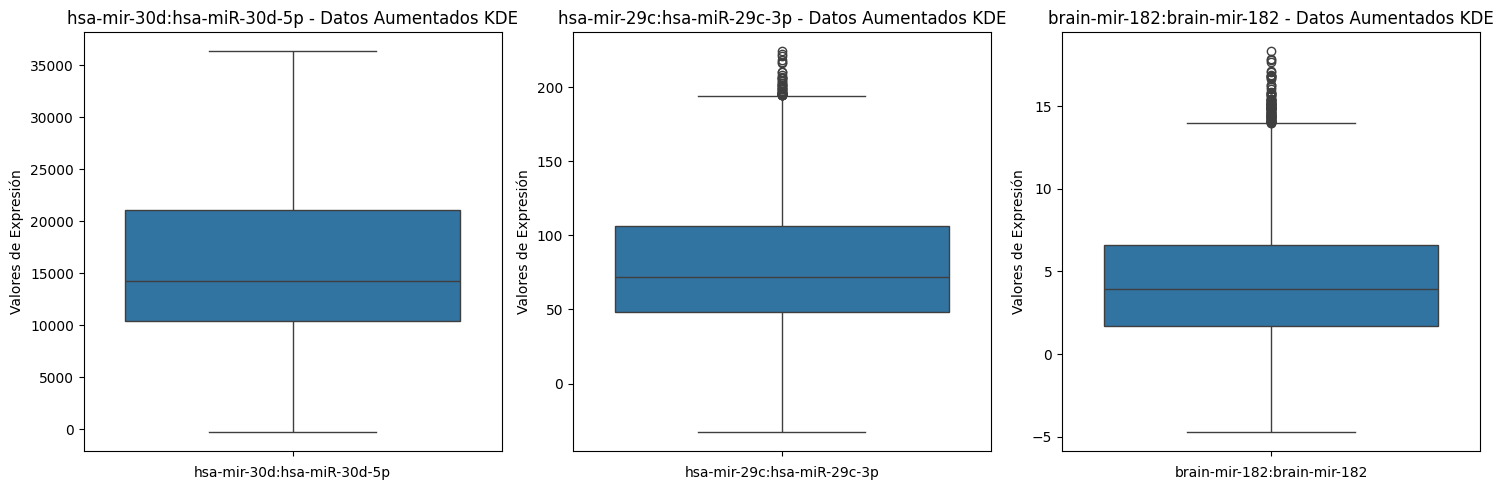

In [ ]:
# Estadísticas descriptivas para los datos aumentados con KDE
mean_augmented_K = augmented_data_K.mean()
variance_augmented_K = augmented_data_K.var()

# Crear DataFrames para medias y varianzas
mean_augmented_K_df = mean_augmented_K.to_frame(name="Media")
variance_augmented_K_df = variance_augmented_K.to_frame(name="Varianza")

print("Medias - Datos Aumentados KDE")
print(mean_augmented_K_df)
print("\nVarianzas - Datos Aumentados KDE")
print(variance_augmented_K_df)

#Histograma
plt.figure(figsize=(15, 5))
for i, column in enumerate(augmented_data_K.columns[:-1], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=augmented_data_K[column])
    plt.title(f'{column} - Datos Aumentados KDE')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()


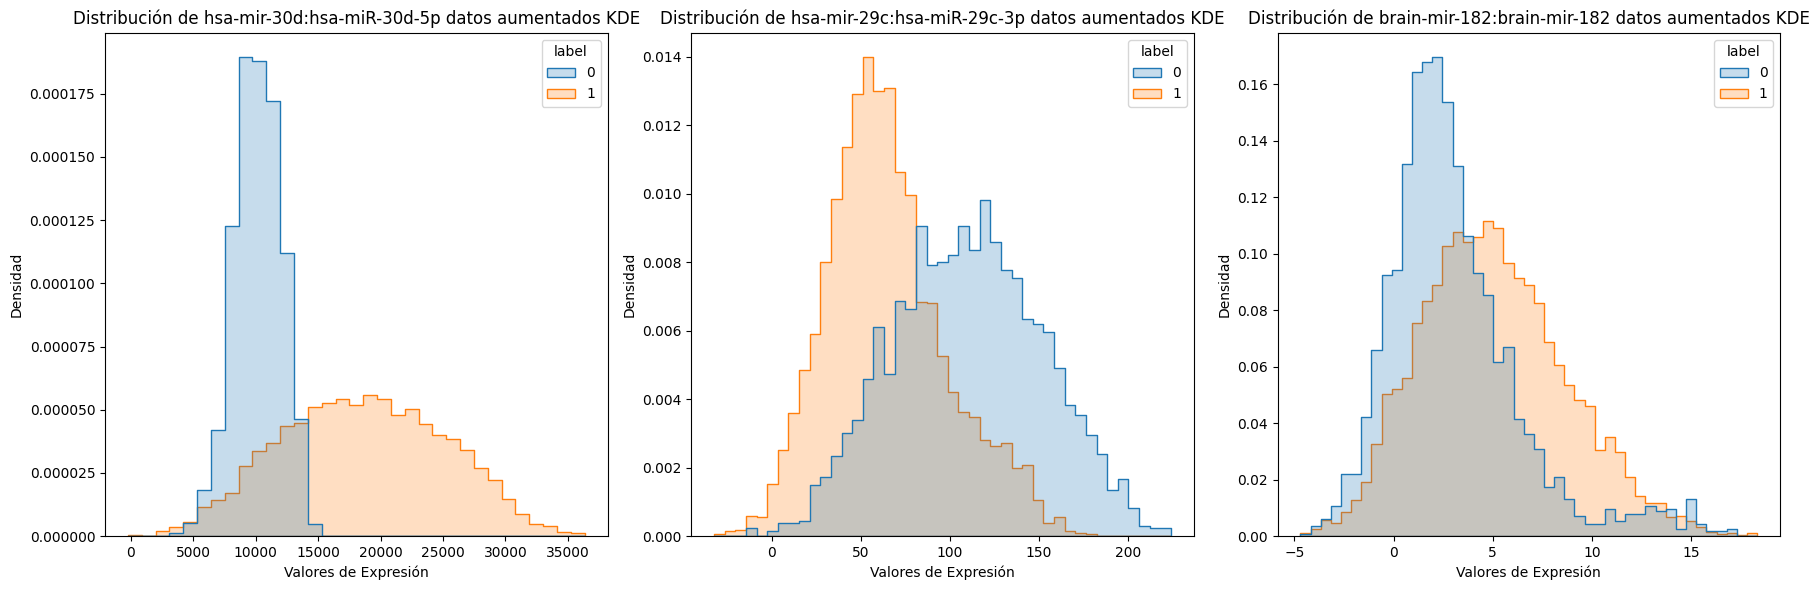

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, column in enumerate(['hsa-mir-30d:hsa-miR-30d-5p', 'hsa-mir-29c:hsa-miR-29c-3p', 'brain-mir-182:brain-mir-182']):
    sns.histplot(data=augmented_data_K, x=column, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribución de {column} datos aumentados KDE')
    axes[i].set_xlabel('Valores de Expresión')
    axes[i].set_ylabel('Densidad')
plt.tight_layout()
plt.show()


## Entrenamiento y evaluación de los modelos para datos origianles

In [ ]:
# Dividir los datos
X = features_3_miRNAs.drop('label', axis=1)
y = features_3_miRNAs['label']

print("\nEvaluación con datos originales:")

# Evaluación de cada modelo
for model in models:
    evaluate_model(model, X, y, skf)


Evaluación con datos originales:
SVC - Accuracy scores: 0.9428571428571428
SVC - Precision scores: 0.9800000000000001
SVC - Recall scores: 0.9377777777777776
SVC - F1 scores: 0.9577089783281734
SVC - AUC scores for each fold are: [0.975 1.    1.    1.    1.   ]
SVC - Average AUC score: 0.9949999999999999
RandomForestClassifier - Accuracy scores: 0.9142857142857144
RandomForestClassifier - Precision scores: 0.9284848484848485
RandomForestClassifier - Recall scores: 0.9577777777777777
RandomForestClassifier - F1 scores: 0.939477034833072
RandomForestClassifier - AUC scores for each fold are: [1.    0.925 1.    1.    1.   ]
RandomForestClassifier - Average AUC score: 0.985
KNeighborsClassifier - Accuracy scores: 0.9285714285714286
KNeighborsClassifier - Precision scores: 0.9418181818181818
KNeighborsClassifier - Recall scores: 0.9577777777777777
KNeighborsClassifier - F1 scores: 0.9481851688043639
KNeighborsClassifier - AUC scores for each fold are: [0.975      0.9875     1.         0.94

## Entrenamiento y evaluación de los modelos para datos aumentados MWO

In [ ]:
# Dividir los datos en características y etiquetas
X_augmented = augmented_data.drop('label', axis=1)
y_augmented = augmented_data['label']

print("\nEvaluación con datos aumentados MWO:")
# Evaluación de cada modelo
for model in models:
  evaluate_model(model, X_augmented, y_augmented, skf)


Evaluación con datos aumentados MWO:
SVC - Accuracy scores: 0.9956152758132955
SVC - Precision scores: 1.0
SVC - Recall scores: 0.9936059068228487
SVC - F1 scores: 0.9967913683194005
SVC - AUC scores for each fold are: [0.99984211 0.99997678 0.99994427 0.99997217 0.99991187]
SVC - Average AUC score: 0.9999294422197073
RandomForestClassifier - Accuracy scores: 0.9991513437057993
RandomForestClassifier - Precision scores: 1.0
RandomForestClassifier - Recall scores: 0.9987624610343324
RandomForestClassifier - F1 scores: 0.9993804851214934
RandomForestClassifier - AUC scores for each fold are: [1.         0.999762   0.99999768 0.99999536 1.        ]
RandomForestClassifier - Average AUC score: 0.9999510088395267
KNeighborsClassifier - Accuracy scores: 0.9983026874115983
KNeighborsClassifier - Precision scores: 0.9993803780696953
KNeighborsClassifier - Recall scores: 0.9981436915514985
KNeighborsClassifier - F1 scores: 0.9987613966858564
KNeighborsClassifier - AUC scores for each fold are: 

## Entrenamiento y evaluación de los modelos para datos aumentados KDE:

In [ ]:

# Dividir los datos aumentados
X_augmented_K = augmented_data_K.drop('label', axis=1)
y_augmented_K = augmented_data_K['label']

print("\nEvaluación con datos aumentados KDE:")
for model in models:
    evaluate_model(model, X_augmented_K, y_augmented_K, skf)



Evaluación con datos aumentados KDE:
SVC - Accuracy scores: 0.9291371994342292
SVC - Precision scores: 0.9590595111116885
SVC - Recall scores: 0.936673582075261
SVC - F1 scores: 0.9477257710256535
SVC - AUC scores for each fold are: [0.98079549 0.97840856 0.97732888 0.97789219 0.97584907]
SVC - Average AUC score: 0.9780548369269632
RandomForestClassifier - Accuracy scores: 0.9345120226308345
RandomForestClassifier - Precision scores: 0.9568749018744844
RandomForestClassifier - Recall scores: 0.9471918121562244
RandomForestClassifier - F1 scores: 0.9520033513841775
RandomForestClassifier - AUC scores for each fold are: [0.98683593 0.98195064 0.98303381 0.98285502 0.97874561]
RandomForestClassifier - Average AUC score: 0.9826842015737135
KNeighborsClassifier - Accuracy scores: 0.9347949080622348
KNeighborsClassifier - Precision scores: 0.9601389271685254
KNeighborsClassifier - Recall scores: 0.9440977519602523
KNeighborsClassifier - F1 scores: 0.9520424524624163
KNeighborsClassifier - A

# Modelo 12 variables

## Selección de características para el modelo de 12 variables

In [ ]:
# Lista de miRNAs seleccionadas
selected_miRNAs = [
    "brain-miR-112", "brain-miR-161", "hsa-let-7d-3p", "hsa-miR-5010-3p",
    "hsa-miR-26a-5p", "hsa-miR-1285-5p", "hsa-miR-151a-3p", "hsa-miR-103a-3p",
    "hsa-miR-107", "hsa-miR-532-5p", "hsa-miR-26b-5p", "hsa-let-7f-5p"
]
found_miRNAs_transposed_12 = {miRNA: col for col in new_columns for miRNA in selected_miRNAs if miRNA.lower() in col.lower()}

if len(found_miRNAs_transposed_12) != 12:
    print("Error: no se encontraron todas las miRNAs. Revisar nombres y disponibilidad en los datos.")

# Extraemos las columnas de interés para las miRNAs seleccionadas
features_12_miRNAs = data_transposed[[found_miRNAs_transposed_12[miRNA] for miRNA in selected_miRNAs]].copy()

# Añadimos una columna de etiquetas
labels12 = ['AD' if 'AD' in label else 'control' for label in features_12_miRNAs.index]
labels12_binary = [1 if label == 'AD' else 0 for label in labels12]
features_12_miRNAs.loc[:, 'label'] = labels12_binary

# Mostrando las primeras filas para verificar la preparación de los datos
print(features_12_miRNAs.head())
#print(features_12_miRNAs['label'].value_counts())

Unnamed: 0  brain-mir-112:brain-mir-112  brain-mir-161:brain-mir-161  \
AD                             7.314286                    27.035714   
AD.1                          14.028571                    12.750000   
AD.2                          18.542857                    21.628571   
AD.3                          15.428571                    15.428571   
AD.4                          20.314286                    15.328571   

Unnamed: 0  hsa-let-7d:hsa-let-7d-3p  hsa-mir-5010:hsa-miR-5010-3p  \
AD                        442.457143                    179.371429   
AD.1                      269.785714                    209.657143   
AD.2                      689.014286                    253.578571   
AD.3                      958.457143                    282.371429   
AD.4                      848.214286                    236.157143   

Unnamed: 0  hsa-mir-26a-1:hsa-miR-26a-5p  hsa-mir-1285-1:hsa-miR-1285-5p  \
AD                           7038.985714                        5.9428

### Análisis estadístico de las características para datos originales:

Medias - Datos Originales
                                       Media
Unnamed: 0                                  
brain-mir-112:brain-mir-112        12.679796
brain-mir-161:brain-mir-161        23.443776
hsa-let-7d:hsa-let-7d-3p          641.050816
hsa-mir-5010:hsa-miR-5010-3p      190.450000
hsa-mir-26a-1:hsa-miR-26a-5p     7929.635714
hsa-mir-1285-1:hsa-miR-1285-5p      9.252041
hsa-mir-151a:hsa-miR-151a-3p     4641.175510
hsa-mir-103a-1:hsa-miR-103a-3p   5737.375816
hsa-mir-107:hsa-miR-107          5067.018776
hsa-mir-532:hsa-miR-532-5p        600.396633
hsa-mir-26b:hsa-miR-26b-5p        745.195918
hsa-let-7f-1:hsa-let-7f-5p      13125.052551
label                               0.685714

Varianzas - Datos Originales
                                    Varianza
Unnamed: 0                                  
brain-mir-112:brain-mir-112     8.467394e+01
brain-mir-161:brain-mir-161     1.465332e+02
hsa-let-7d:hsa-let-7d-3p        4.328308e+05
hsa-mir-5010:hsa-miR-5010-3p    1.346748e+04

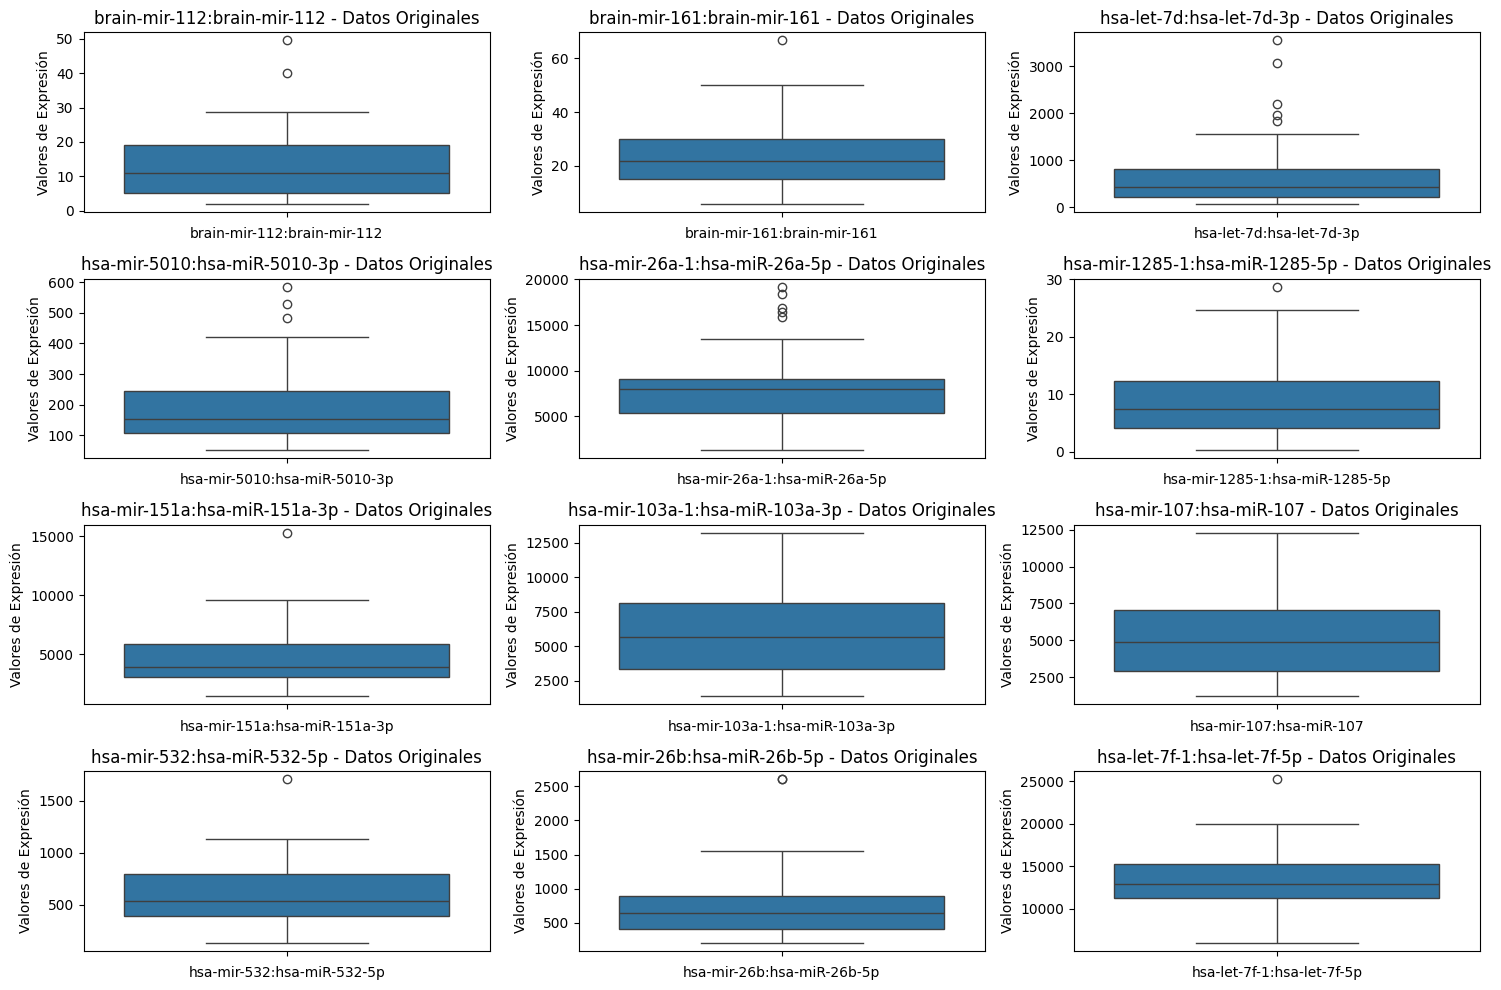

In [ ]:
# Estadísticas descriptivas para los datos originales
mean_original = features_12_miRNAs.mean()
variance_original = features_12_miRNAs.var()

mean_original_df = mean_original.to_frame(name="Media")
variance_original_df = variance_original.to_frame(name="Varianza")

print("Medias - Datos Originales")
print(mean_original_df)
print("\nVarianzas - Datos Originales")
print(variance_original_df)

# Generación de boxplots para cada miRNA
plt.figure(figsize=(15, 10))
for i, column in enumerate(features_12_miRNAs.columns[:-1], 1):  # Excluyendo la columna 'label'
    ax = plt.subplot(4, 3, i)
    sns.boxplot(y=features_12_miRNAs[column])
    plt.title(f'{column} - Datos Originales')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()


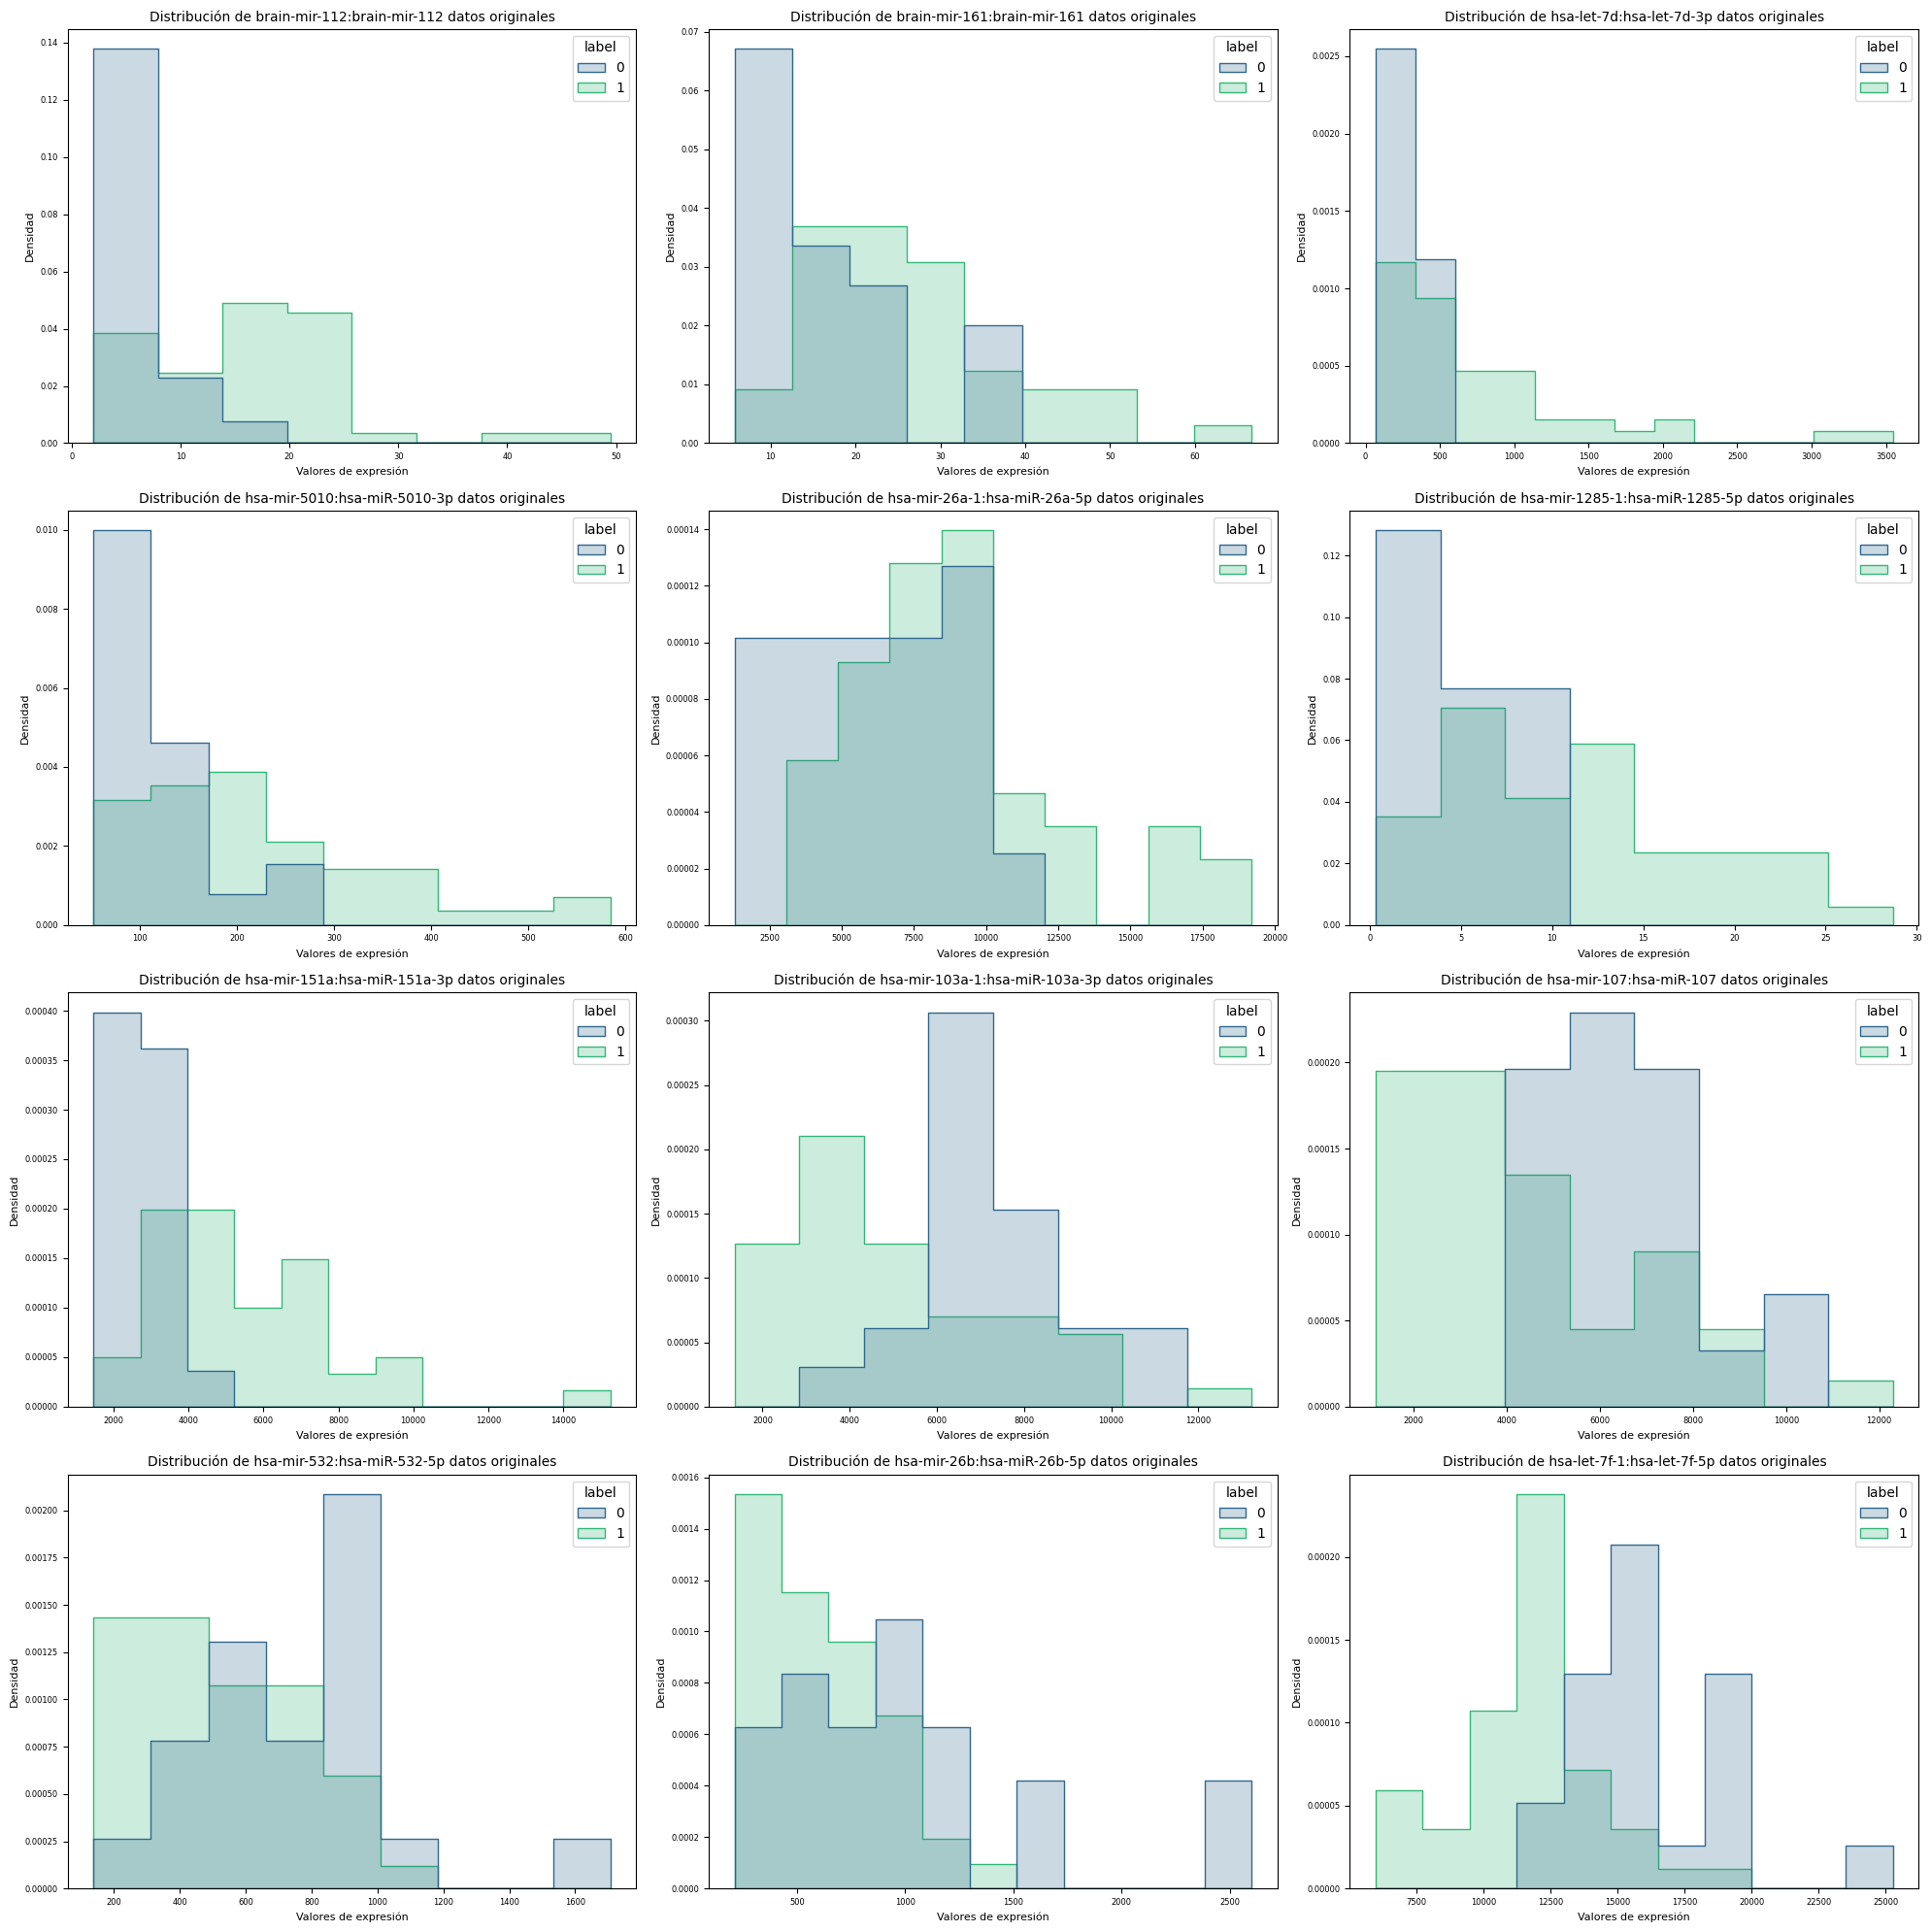

In [ ]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(features_12_miRNAs.columns[:-1], 1):
    ax = plt.subplot(4, 3, i)
    plot = sns.histplot(data=features_12_miRNAs, x=column, hue='label', element='step', stat='density', common_norm=False, palette='viridis', legend=True)
    plt.title(f'Distribución de {column} datos originales', fontsize=10)
    plt.xlabel('Valores de expresión', fontsize=8)
    plt.ylabel('Densidad', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()


## Aumento de datos MWO

In [ ]:
# Contar las muestras originales para cada etiqueta en features_12_miRNAs
n_AD_original_12 = sum(features_12_miRNAs['label'] == 1)
n_control_original_12 = sum(features_12_miRNAs['label'] == 0)

# Suponiendo que generate_synthetic_samples es una función que ya tienes definida para generar muestras sintéticas
synthetic_AD_12 = generate_synthetic_samples(features_12_miRNAs[features_12_miRNAs['label'] == 1], 100 * n_AD_original_12)
synthetic_control_12 = generate_synthetic_samples(features_12_miRNAs[features_12_miRNAs['label'] == 0], 100 * n_control_original_12)

# Combinar los datos originales con los datos sintéticos
augmented_data_12 = pd.concat([features_12_miRNAs, synthetic_AD_12, synthetic_control_12])
augmented_data_12 = augmented_data_12.sample(frac=1).reset_index(drop=True)  # Mezclar los datos para evitar cualquier sesgo en el orden

# Contar y mostrar el número de muestras generadas para cada tipo
n_AD_augmented_12 = len(synthetic_AD_12)
n_control_augmented_12 = len(synthetic_control_12)

print(f"Generated samples for AD: {n_AD_augmented_12}")
print(f"Generated samples for Control: {n_control_augmented_12}")


Generated samples for AD: 4800
Generated samples for Control: 2200


### Análisis estadístico de las características para datos aumentados MWO:

Medias - Datos Aumentados
                                       Media
Unnamed: 0                                  
brain-mir-112:brain-mir-112        12.641887
brain-mir-161:brain-mir-161        23.467646
hsa-let-7d:hsa-let-7d-3p          643.593744
hsa-mir-5010:hsa-miR-5010-3p      189.613088
hsa-mir-26a-1:hsa-miR-26a-5p     7901.587207
hsa-mir-1285-1:hsa-miR-1285-5p      9.182144
hsa-mir-151a:hsa-miR-151a-3p     4612.286811
hsa-mir-103a-1:hsa-miR-103a-3p   5773.997168
hsa-mir-107:hsa-miR-107          5102.129898
hsa-mir-532:hsa-miR-532-5p        603.447667
hsa-mir-26b:hsa-miR-26b-5p        747.673162
hsa-let-7f-1:hsa-let-7f-5p      13154.943430
label                               0.685714

Varianzas - Datos Aumentados
                                    Varianza
Unnamed: 0                                  
brain-mir-112:brain-mir-112     6.243410e+01
brain-mir-161:brain-mir-161     1.036953e+02
hsa-let-7d:hsa-let-7d-3p        3.196666e+05
hsa-mir-5010:hsa-miR-5010-3p    9.421832e+03

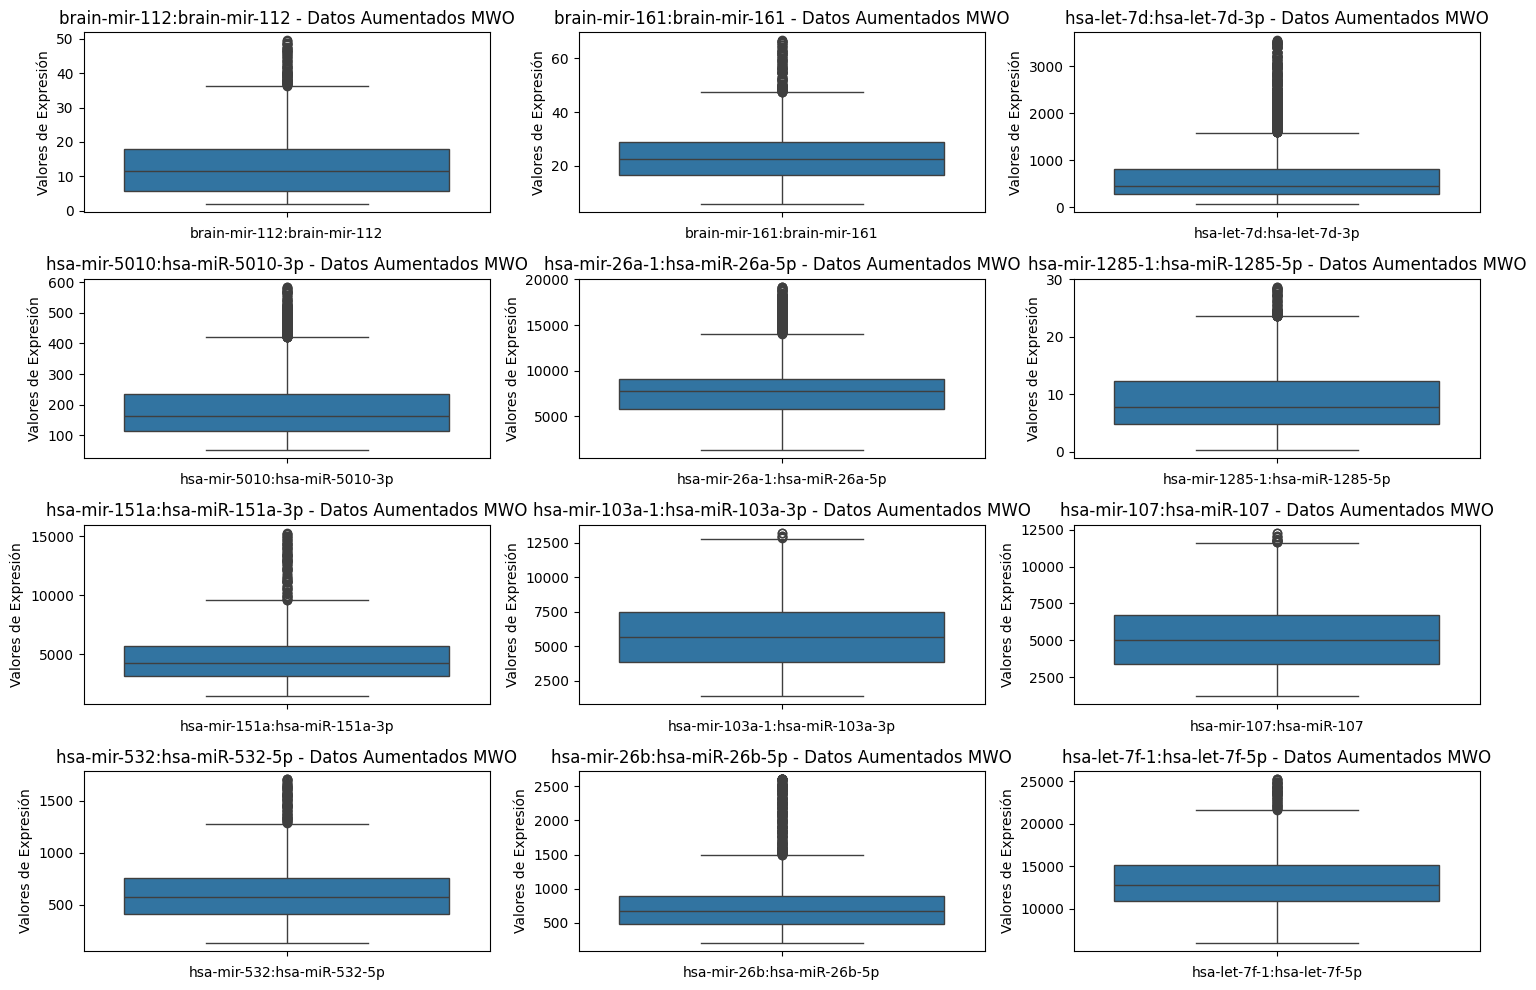

In [ ]:
# Estadísticas descriptivas para los datos aumentados
mean_augmented = augmented_data_12.mean()
variance_augmented = augmented_data_12.var()

mean_augmented_df = mean_augmented.to_frame(name="Media")
variance_augmented_df = variance_augmented.to_frame(name="Varianza")

print("Medias - Datos Aumentados")
print(mean_augmented_df)
print("\nVarianzas - Datos Aumentados")
print(variance_augmented_df)

# Generación de boxplots para cada miRNA en los datos aumentados
plt.figure(figsize=(15, 10))
for i, column in enumerate(augmented_data_12.columns[:-1], 1):  # Excluyendo la columna 'label'
    ax = plt.subplot(4, 3, i)
    sns.boxplot(y=augmented_data_12[column])
    plt.title(f'{column} - Datos Aumentados MWO')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()


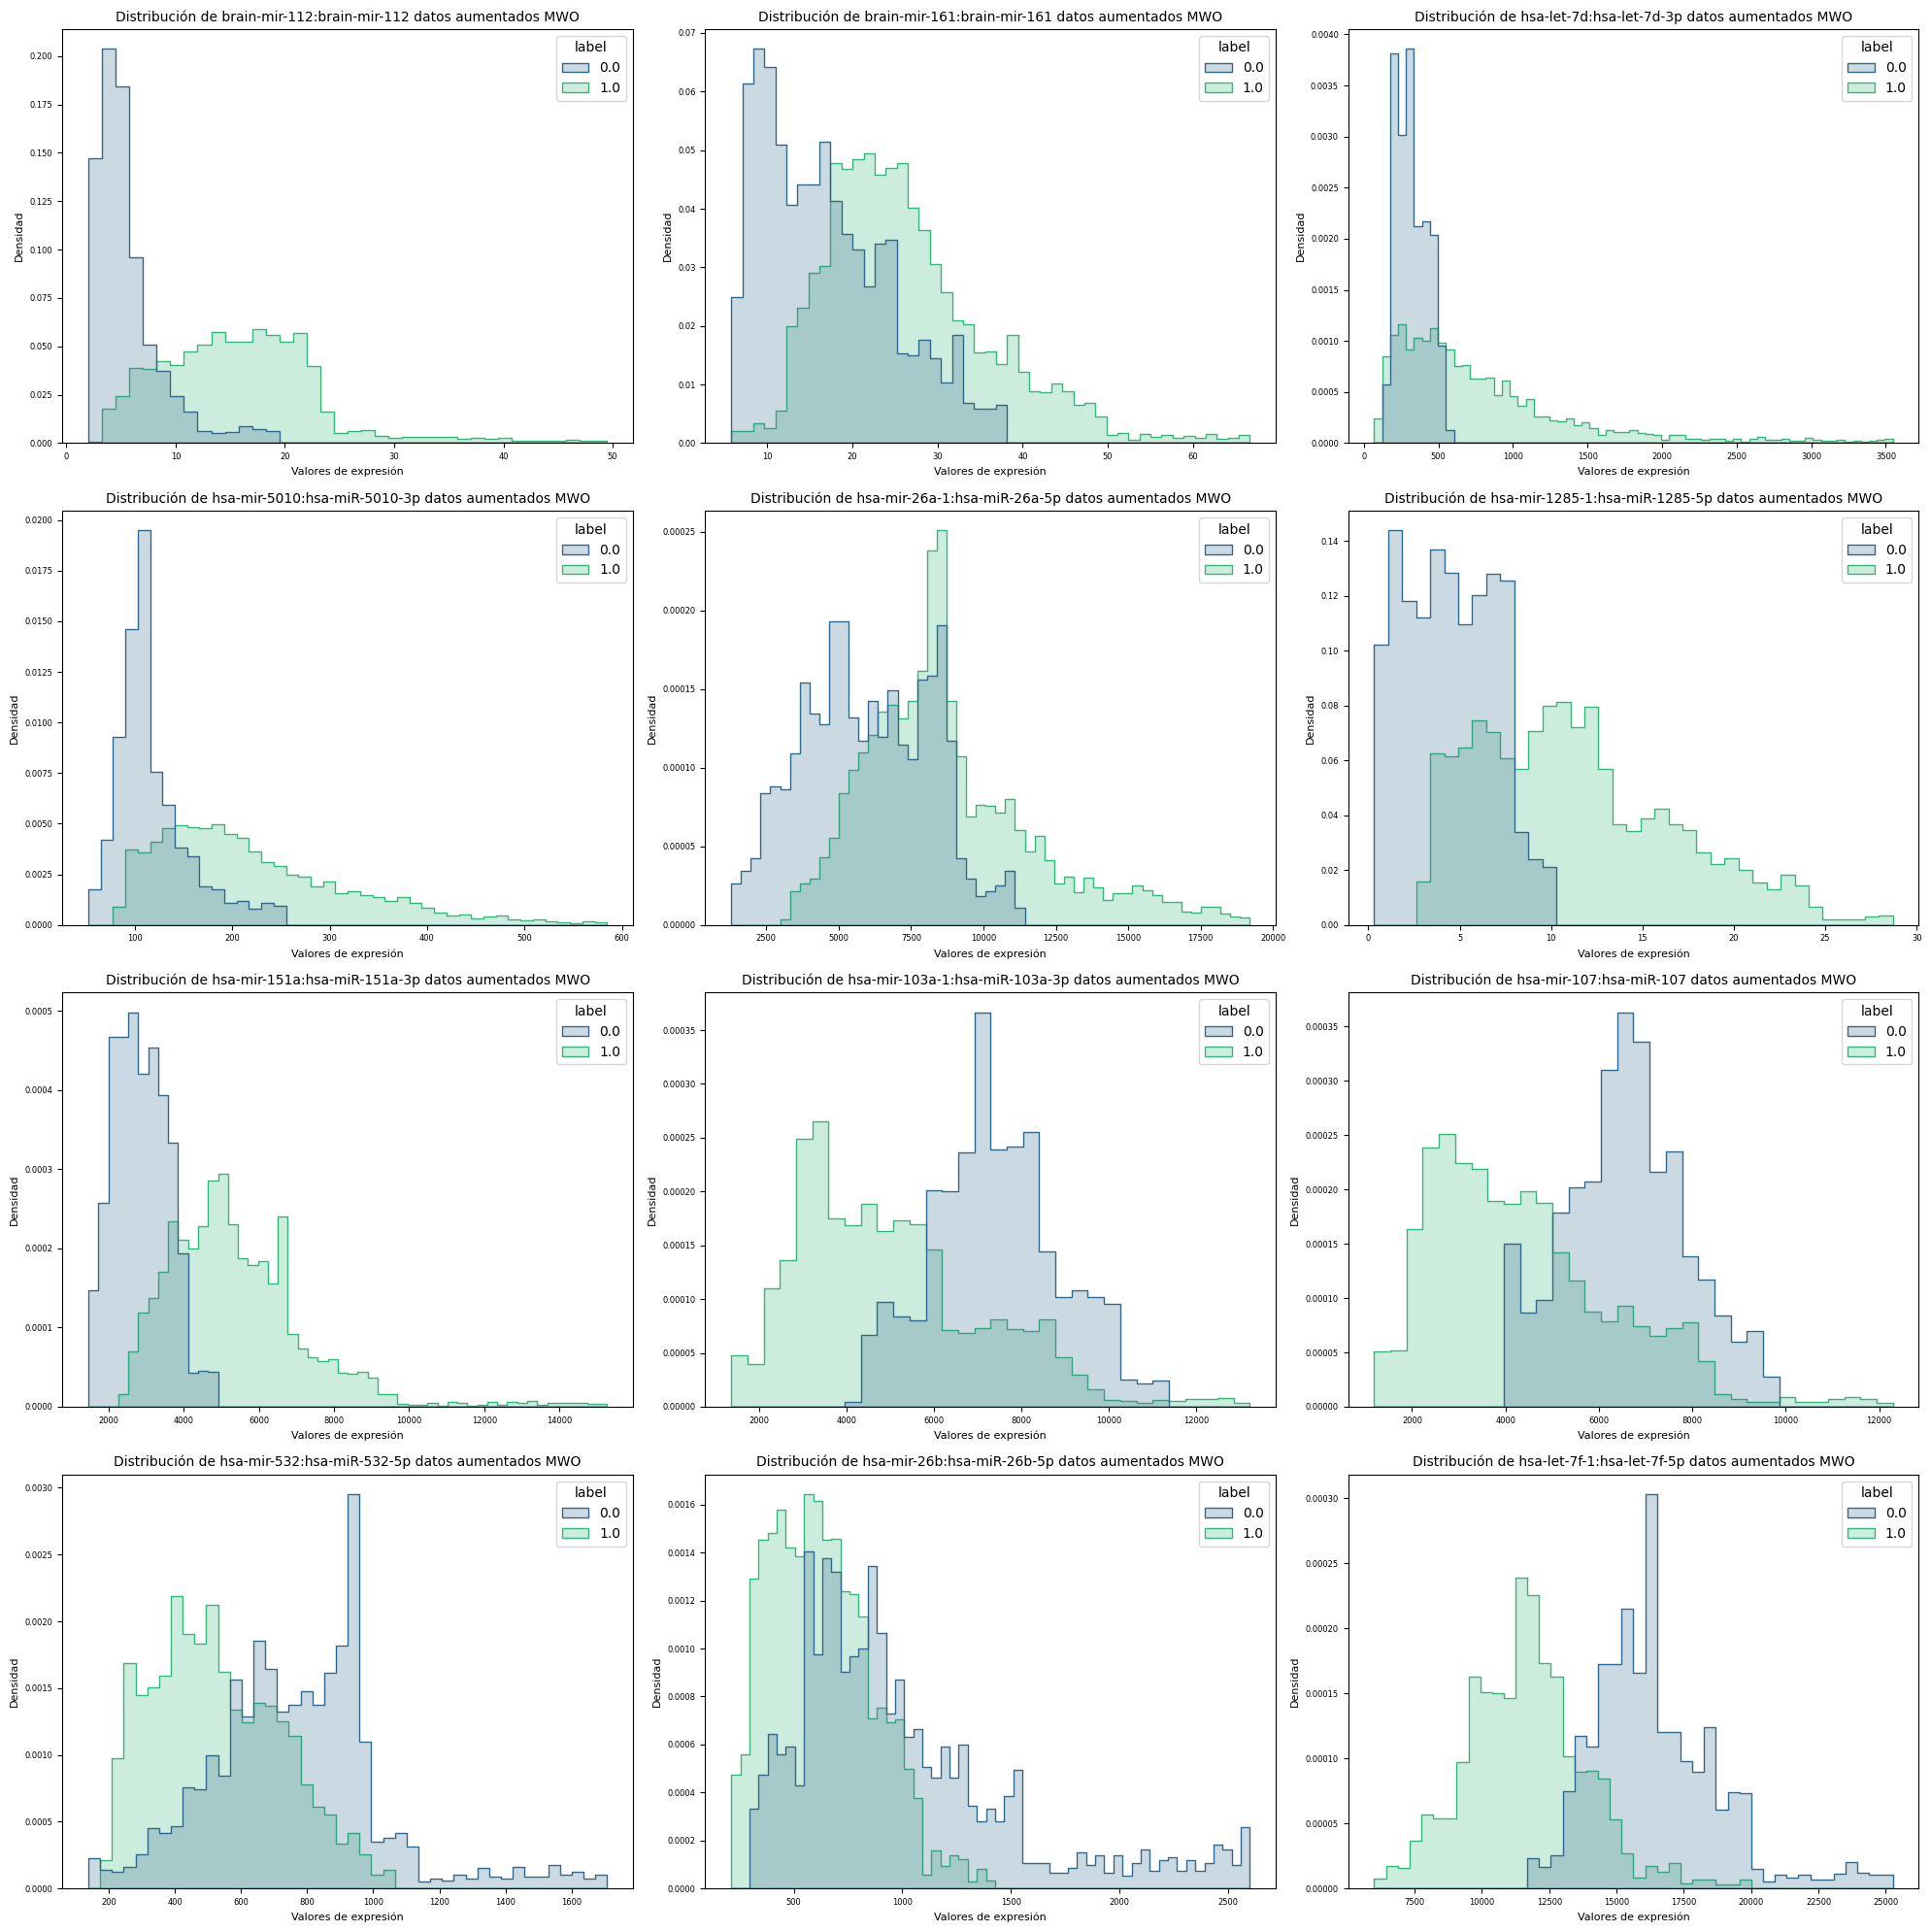

In [ ]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(augmented_data_12.columns[:-1], 1):
    ax = plt.subplot(4, 3, i)
    plot = sns.histplot(data=augmented_data_12, x=column, hue='label', element='step', stat='density', common_norm=False, palette='viridis', legend=True)
    plt.title(f'Distribución de {column} datos aumentados MWO', fontsize=10)
    plt.xlabel('Valores de expresión', fontsize=8)
    plt.ylabel('Densidad', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

## Aumento de datos KDE:

In [ ]:
# Contar las muestras originales para cada etiqueta en features_12_miRNAs
n_AD_original = sum(features_12_miRNAs['label'] == 1)
n_control_original = sum(features_12_miRNAs['label'] == 0)

# Generar datos sintéticos
synthetic_AD_K12 = generate_synthetic_samples_kde(features_12_miRNAs[features_12_miRNAs['label'] == 1].drop(columns='label'), 100 * n_AD_original)
synthetic_control_K12 = generate_synthetic_samples_kde(features_12_miRNAs[features_12_miRNAs['label'] == 0].drop(columns='label'), 100 * n_control_original)

# Añadir columna de etiquetas a los datos sintéticos
synthetic_AD_K12['label'] = 1
synthetic_control_K12['label'] = 0

# Combinar con los datos originales
augmented_data_K12 = pd.concat([features_12_miRNAs, synthetic_AD_K12, synthetic_control_K12])
augmented_data_K12 = augmented_data_K12.sample(frac=1).reset_index(drop=True)  # Mezclar los datos

# Contar y mostrar el número de muestras generadas
n_AD_augmented_K12 = len(synthetic_AD_K12)
n_control_augmented_K12 = len(synthetic_control_K12)
print(f"Generated samples for AD: {n_AD_augmented_K12}")
print(f"Generated samples for Control: {n_control_augmented_K12}")

Generated samples for AD: 4800
Generated samples for Control: 2200


### Análisis estadístico de las características para datos aumentados aumentados KDE:

Medias - Datos Aumentados
                                       Media
Unnamed: 0                                  
brain-mir-112:brain-mir-112        12.695368
brain-mir-161:brain-mir-161        23.476119
hsa-let-7d:hsa-let-7d-3p          657.007013
hsa-mir-5010:hsa-miR-5010-3p      190.377102
hsa-mir-26a-1:hsa-miR-26a-5p     7930.995236
hsa-mir-1285-1:hsa-miR-1285-5p      9.294500
hsa-mir-151a:hsa-miR-151a-3p     4646.308870
hsa-mir-103a-1:hsa-miR-103a-3p   5749.076345
hsa-mir-107:hsa-miR-107          5074.419270
hsa-mir-532:hsa-miR-532-5p        597.330736
hsa-mir-26b:hsa-miR-26b-5p        742.396494
hsa-let-7f-1:hsa-let-7f-5p      13179.067304
label                               0.685714

Varianzas - Datos Aumentados
                                    Varianza
Unnamed: 0                                  
brain-mir-112:brain-mir-112     1.204722e+02
brain-mir-161:brain-mir-161     2.284930e+02
hsa-let-7d:hsa-let-7d-3p        6.808506e+05
hsa-mir-5010:hsa-miR-5010-3p    2.086069e+04

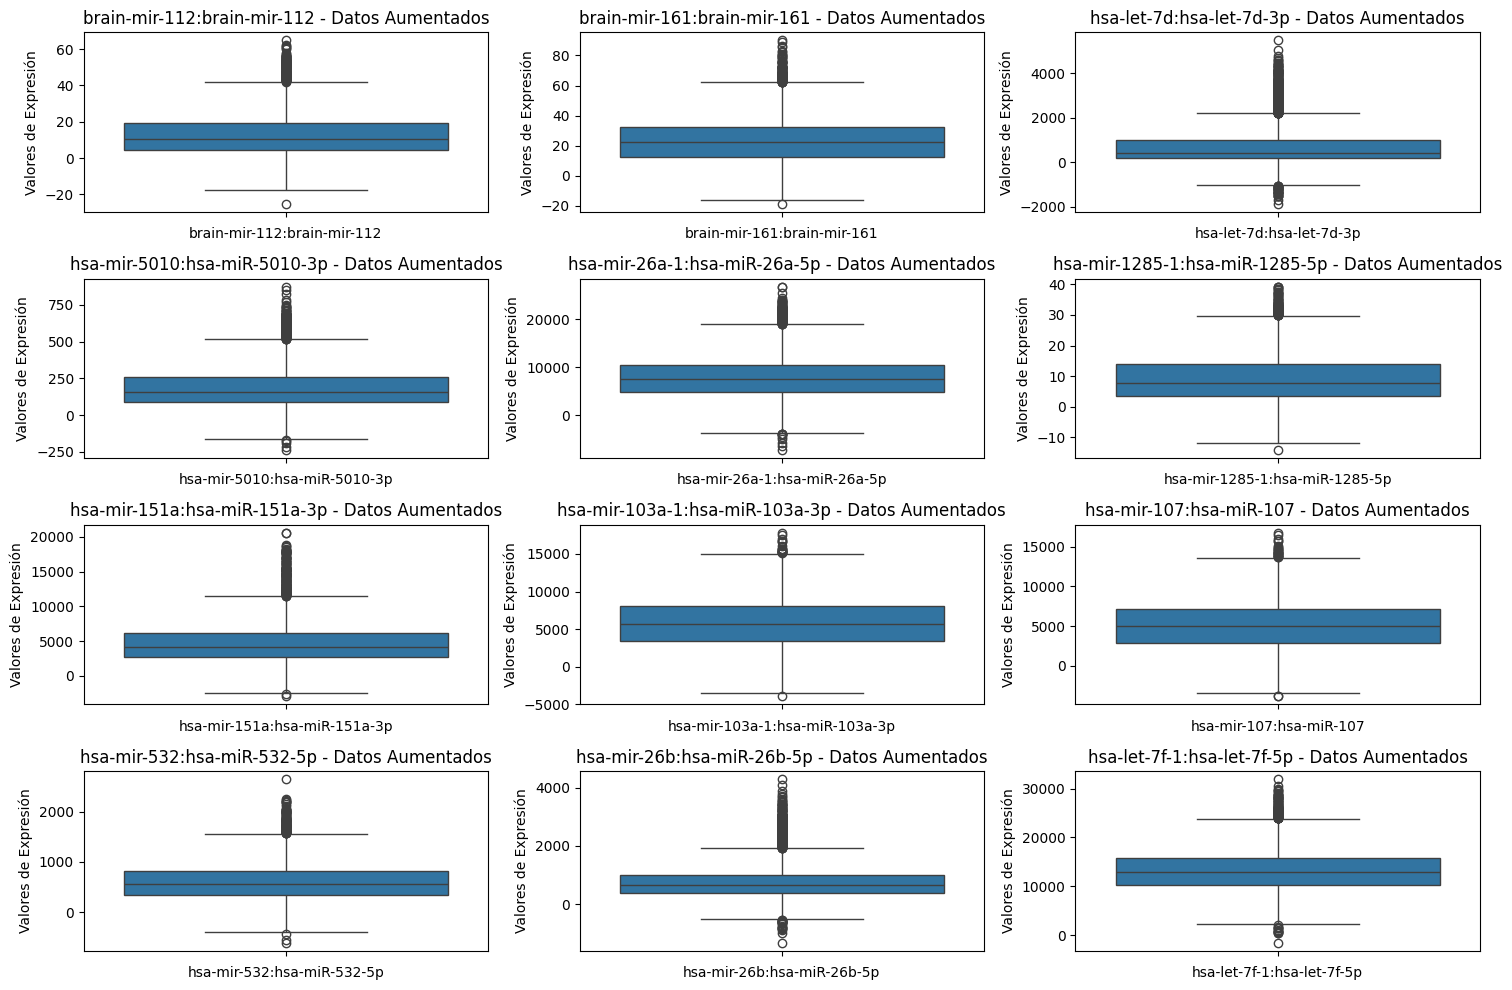

In [ ]:
# Estadísticas descriptivas para los datos aumentados
mean_augmented = augmented_data_K12.mean()
variance_augmented = augmented_data_K12.var()

mean_augmented_df = mean_augmented.to_frame(name="Media")
variance_augmented_df = variance_augmented.to_frame(name="Varianza")

print("Medias - Datos Aumentados")
print(mean_augmented_df)
print("\nVarianzas - Datos Aumentados")
print(variance_augmented_df)

# Generación de boxplots para cada miRNA en los datos aumentados
plt.figure(figsize=(15, 10))
for i, column in enumerate(augmented_data_K12.columns[:-1], 1):  # Excluyendo la columna 'label'
    ax = plt.subplot(4, 3, i)
    sns.boxplot(y=augmented_data_K12[column])
    plt.title(f'{column} - Datos Aumentados')
    plt.xlabel(column)
    plt.ylabel('Valores de Expresión')
plt.tight_layout()
plt.show()

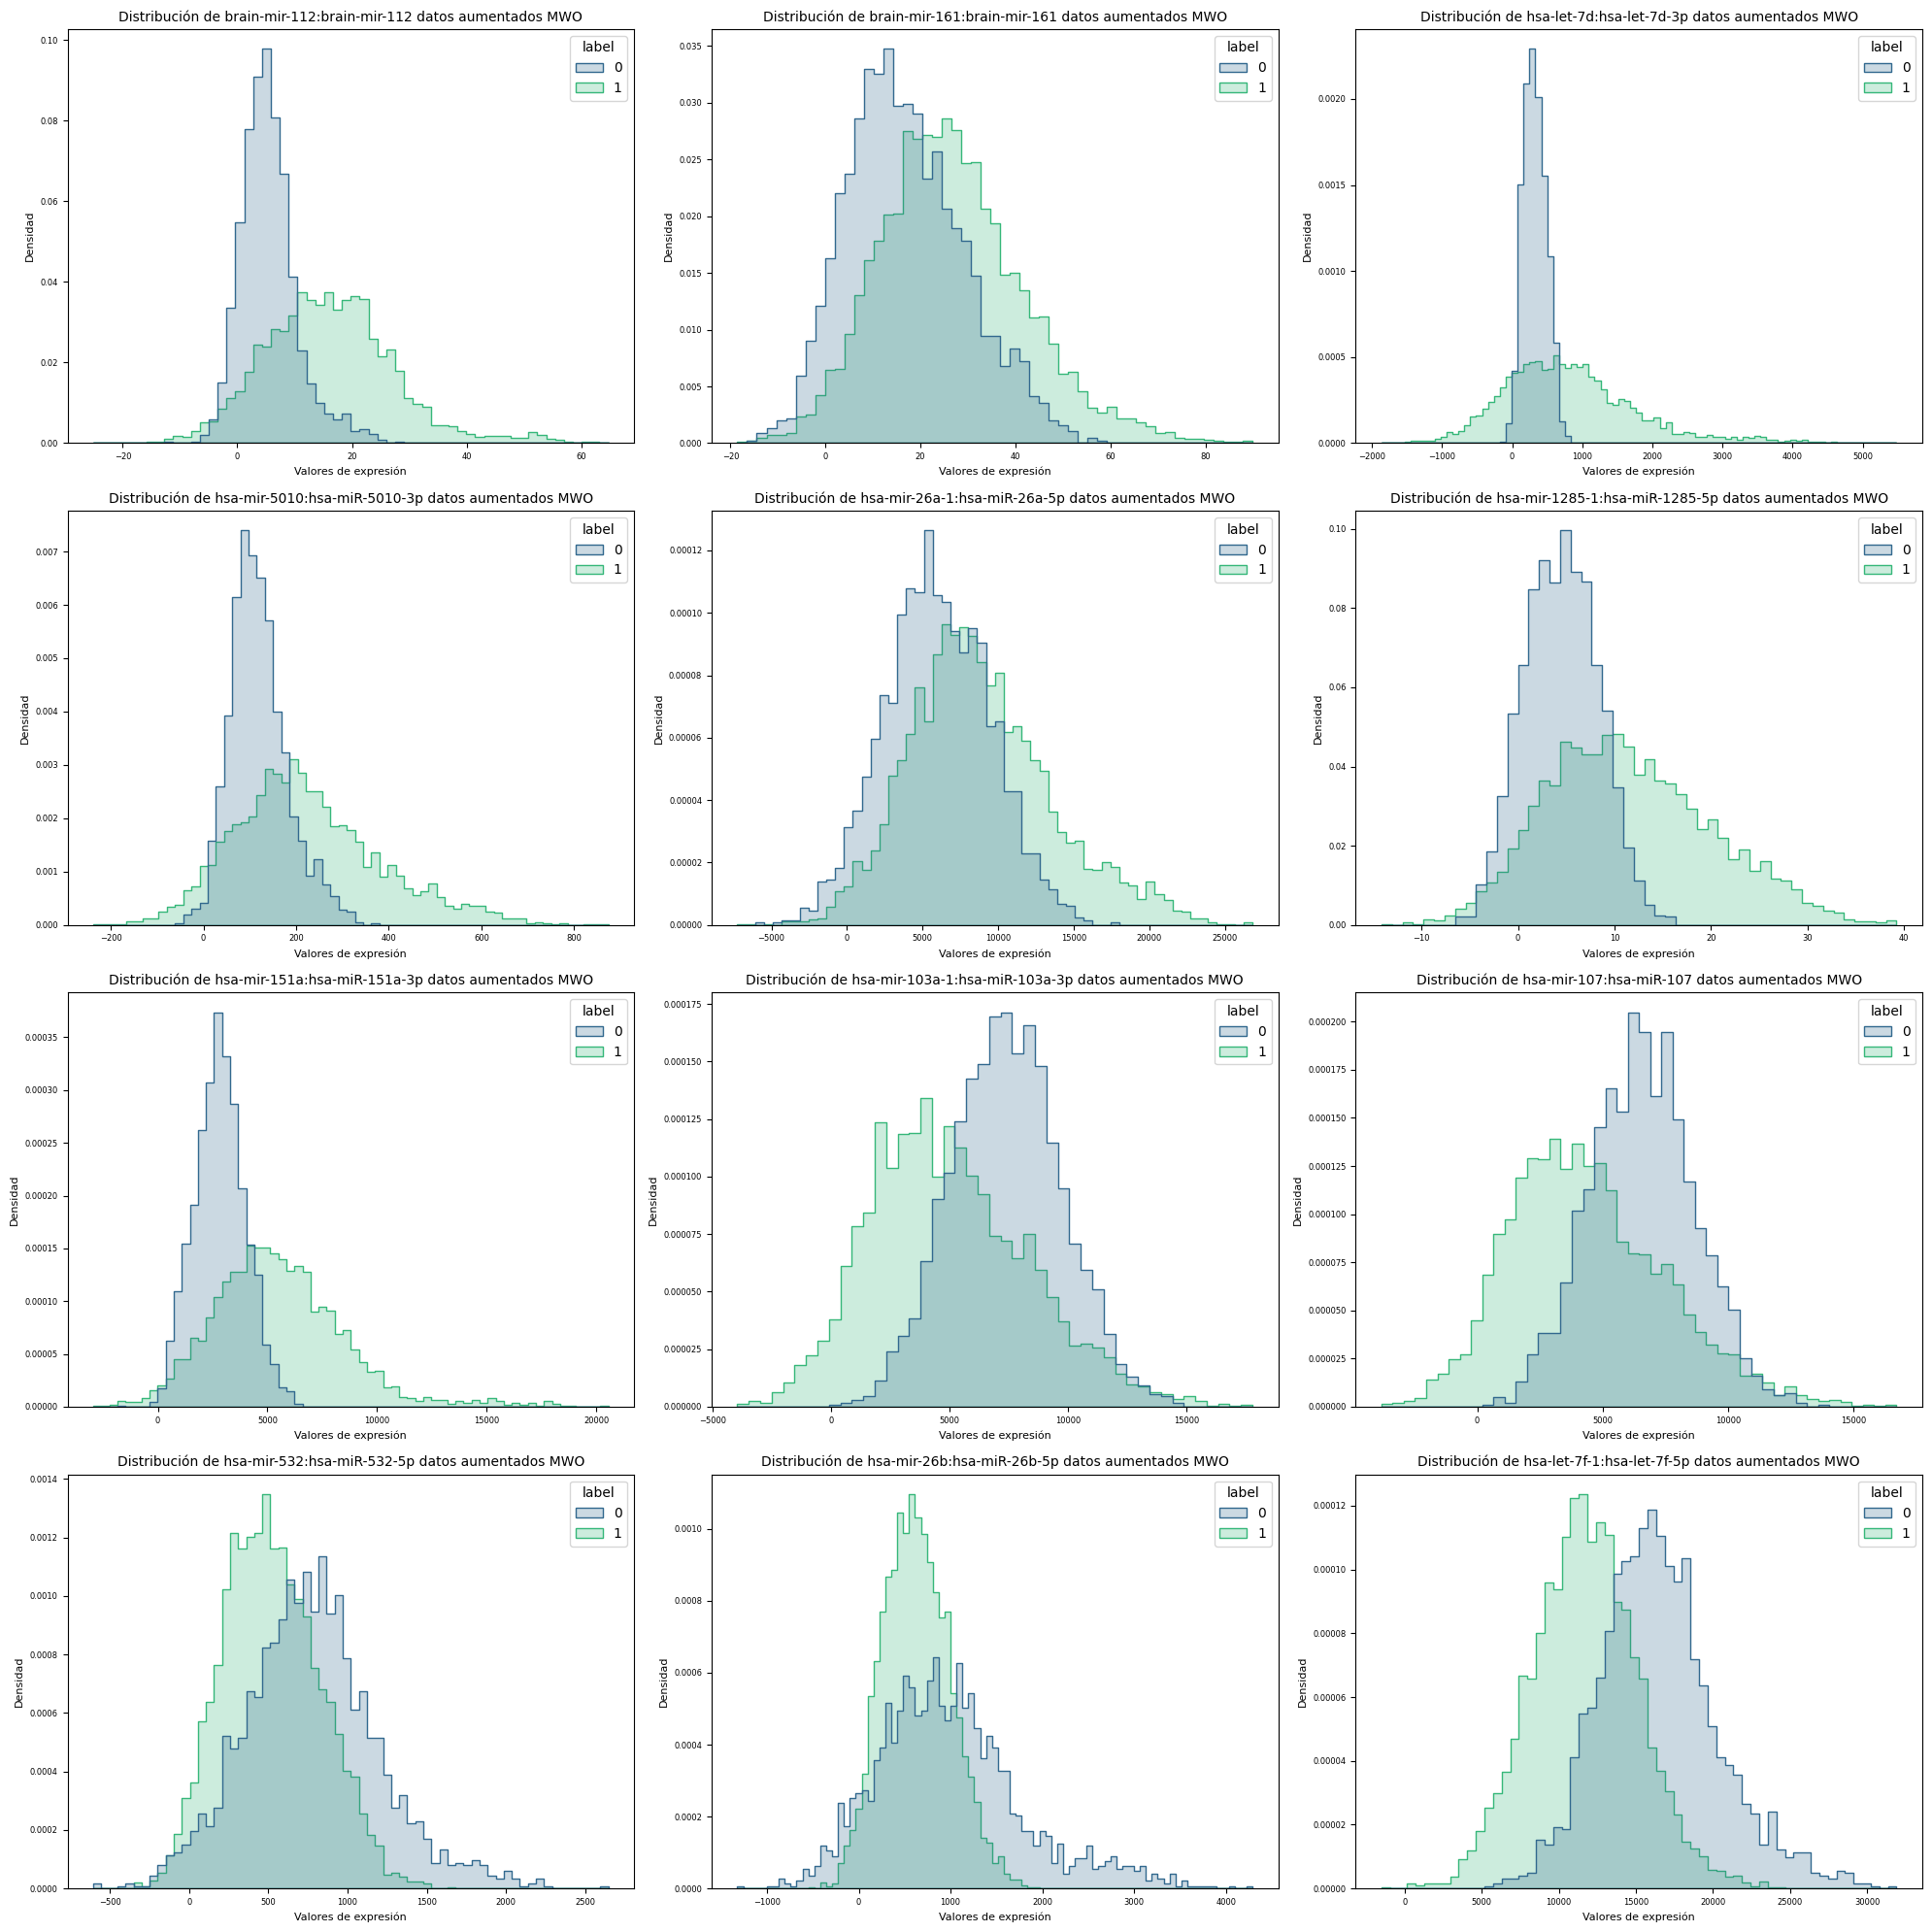

In [ ]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(augmented_data_K12.columns[:-1], 1):
    ax = plt.subplot(4, 3, i)
    plot = sns.histplot(data=augmented_data_K12, x=column, hue='label', element='step', stat='density', common_norm=False, palette='viridis', legend=True)
    plt.title(f'Distribución de {column} datos aumentados MWO', fontsize=10)
    plt.xlabel('Valores de expresión', fontsize=8)
    plt.ylabel('Densidad', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

## Entrenamiento y evaluación de los modelos para datos origianles

In [ ]:
# Dividir los datos
X_12 = features_12_miRNAs.drop('label', axis=1)
y_12 = features_12_miRNAs['label']

print("\nEvaluación con datos originales:")

# Evaluación de cada modelo
for model in models:
    evaluate_model(model, X_12, y_12, skf)



Evaluación con datos originales:
SVC - Accuracy scores: 0.8142857142857143
SVC - Precision scores: 0.8577777777777778
SVC - Recall scores: 0.8777777777777779
SVC - F1 scores: 0.8663157894736843
SVC - AUC scores for each fold are: [0.9        0.975      0.85       1.         0.93333333]
SVC - Average AUC score: 0.9316666666666666
RandomForestClassifier - Accuracy scores: 0.8714285714285716
RandomForestClassifier - Precision scores: 0.8995959595959595
RandomForestClassifier - Recall scores: 0.9177777777777777
RandomForestClassifier - F1 scores: 0.9073182957393484
RandomForestClassifier - AUC scores for each fold are: [0.8875     1.         0.925      1.         0.95555556]
RandomForestClassifier - Average AUC score: 0.9536111111111112
KNeighborsClassifier - Accuracy scores: 0.8714285714285713
KNeighborsClassifier - Precision scores: 0.8709090909090909
KNeighborsClassifier - Recall scores: 0.96
KNeighborsClassifier - F1 scores: 0.9114285714285714
KNeighborsClassifier - AUC scores for eac

## Entrenamiento y evaluación de los modelos para datos aumentados MWO

In [ ]:
# Dividir los datos en características y etiquetas
X_augmented12 = augmented_data_12.drop('label', axis=1)
y_augmented12 = augmented_data_12['label']

print("\nEvaluación con datos aumentados MWO:")
for model in models:
  evaluate_model(model, X_augmented12, y_augmented12, skf)


Evaluación con datos aumentados MWO:
SVC - Accuracy scores: 0.9953323903818954
SVC - Precision scores: 1.0
SVC - Recall scores: 0.9931928973434193
SVC - F1 scores: 0.996581643790336
SVC - AUC scores for each fold are: [1. 1. 1. 1. 1.]
SVC - Average AUC score: 1.0
RandomForestClassifier - Accuracy scores: 0.9994342291371995
RandomForestClassifier - Precision scores: 0.9997940267765191
RandomForestClassifier - Recall scores: 0.9993812305171662
RandomForestClassifier - F1 scores: 0.9995874159744383
RandomForestClassifier - AUC scores for each fold are: [1.         0.99996285 1.         1.         1.        ]
RandomForestClassifier - Average AUC score: 0.999992569889477
KNeighborsClassifier - Accuracy scores: 0.9997171145685997
KNeighborsClassifier - Precision scores: 1.0
KNeighborsClassifier - Recall scores: 0.9995874160841766
KNeighborsClassifier - F1 scores: 0.9997936015962328
KNeighborsClassifier - AUC scores for each fold are: [1.         0.99999768 1.         1.         1.        ]


## Entrenamiento y evaluación de los modelos para datos aumentados KDE:

In [ ]:

# Dividir los datos aumentados
X_augmented_K12 = augmented_data_K12.drop('label', axis=1)
y_augmented_K12 = augmented_data_K12['label']

# Evaluación de cada modelo con datos aumentados
print("\nEvaluación con datos aumentados KDE:")
for model in models:
    evaluate_model(model, X_augmented_K12, y_augmented_K12, skf)



Evaluación con datos aumentados KDE:
SVC - Accuracy scores: 0.8586987270155587
SVC - Precision scores: 0.9110406658205206
SVC - Recall scores: 0.8799504218399242
SVC - F1 scores: 0.895208032248345
SVC - AUC scores for each fold are: [0.93279299 0.92830788 0.92143819 0.918292   0.93372109]
SVC - Average AUC score: 0.9269104309668613
RandomForestClassifier - Accuracy scores: 0.9701555869872701
RandomForestClassifier - Precision scores: 0.9853601288013367
RandomForestClassifier - Recall scores: 0.9709154937069782
RandomForestClassifier - F1 scores: 0.9780782234031214
RandomForestClassifier - AUC scores for each fold are: [0.99637064 0.99430433 0.99646025 0.99585887 0.99717888]
RandomForestClassifier - Average AUC score: 0.9960345944280136
KNeighborsClassifier - Accuracy scores: 0.962093352192362
KNeighborsClassifier - Precision scores: 0.9931283633642863
KNeighborsClassifier - Recall scores: 0.9513182896598684
KNeighborsClassifier - F1 scores: 0.9717563574992057
KNeighborsClassifier - AU

Pasar a html para revision

In [ ]:
!jupyter nbconvert --to html /content/Copia_de_Copia_de_ProgramaFInalv2.ipynb

[NbConvertApp] Converting notebook /content/Copia_de_Copia_de_ProgramaFInalv2.ipynb to html
[NbConvertApp] Writing 2559668 bytes to /content/Copia_de_Copia_de_ProgramaFInalv2.html
